In [2]:
from IPython.display import Audio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

In [3]:
NUM_LABEL_COLS = 13
TEST_SIZE = 0.2
RANDOM_SEED = 0

In [4]:
df = pd.read_pickle('./data/5s/labeled/features_r02/all_data.pkl')

In [5]:
# df_filtered = df[df['excl'] == '0']  # exclude records we want to exclude
df_filtered = df
df_filtered.shape

(9080, 10790)

In [6]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['trmp'] == '0'] 
df_filtered = df_filtered[df_filtered['clrt'] == '0']
df_filtered = df_filtered[df_filtered['othr'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']

num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS - 1
# ^ last bit to adjust for zero indexing
data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ these are the features

In [7]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [8]:
df_filtered['sax'] = df_filtered[['sop', 'alto', 'tenr', 'tora', 'bari']].max(axis=1)
df_filtered['sax'] = df_filtered['sax'].astype(int)
target = df_filtered['sax'].to_numpy().ravel()  
# ^ these are the labels
# df_filtered.head(20)

In [9]:
xs = [n for n in range(4, 60, 1)]
ys = []
for x in xs:
    pca = PCA(n_components=x)
    pca.fit(data)
    d = pca.transform(data)
    x_train, x_test, y_train, y_test = \
         train_test_split(d, target, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    clf = SVC()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    ys.append(clf.score(x_test, y_test))
    

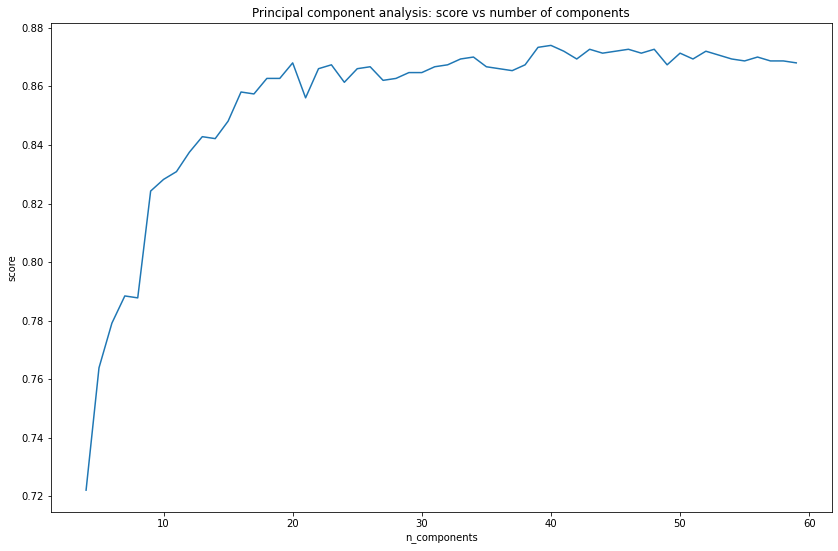

In [10]:
fig = plt.figure(figsize=(14, 9))    
plt.plot(xs, ys)
plt.xlabel('n_components')
plt.ylabel('score')
plt.title("Principal component analysis: score vs number of components")
pass


### Trust the process
Try PCA without supplying n_components and then plot cumulative explained variance

In [11]:
pca = PCA()
pca.fit(data)
# d = pca.transform(data)

PCA()

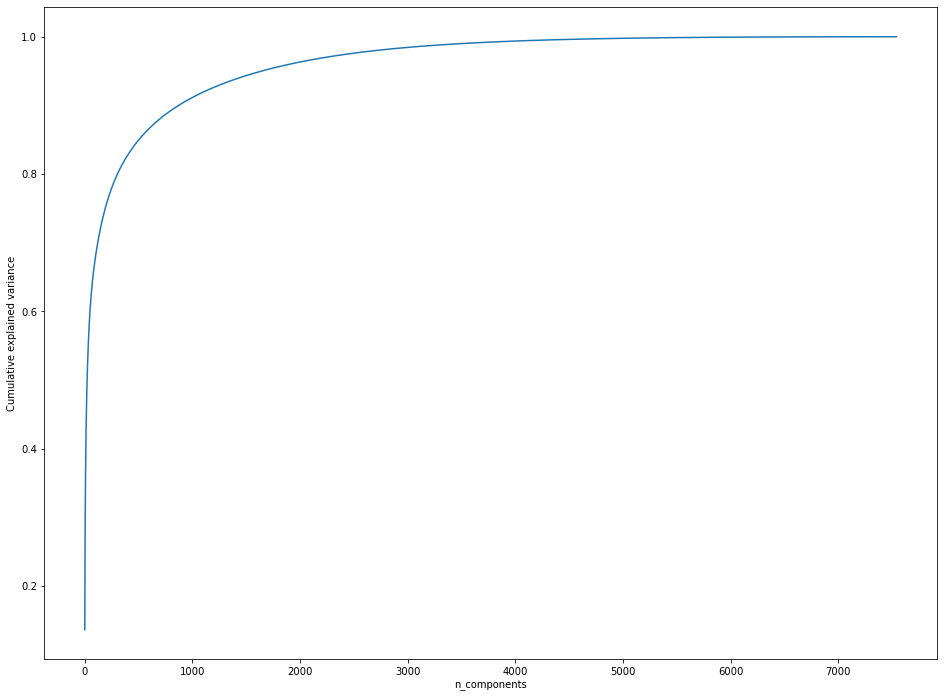

In [12]:
fig = plt.figure(figsize=(16, 12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n_components')
plt.ylabel('Cumulative explained variance');

In [ ]:
# Homegrown grid search
history = {'v': [], 'n_components': [], 'precision': [], 'recall': []}
for v in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]:
    history['v'].append(v)
    pca = PCA(v).fit(data)
    history['n_components'].append(pca.n_components_)
    d = pca.transform(data)
    x_train, x_test, y_train, y_test = \
        train_test_split(d, target,
                         test_size=TEST_SIZE,
                         random_state=RANDOM_SEED)
    clf = SVC()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = clf.score(x_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    history['precision'].append(tp / (tp + fp))
    history['recall'].append(tp / (tp + fn))


In [ ]:
# h = pd.DataFrame(history['n_components'])
# p = pd.DataFrame(history['precision'])
# r = pd.DataFrame(history['recall'])
# h = pd.concat([h, p, r], axis=1)
# h.columns = ['n', 'p', 'r']
# h = h.sort_values('n')
# h['n']


In [ ]:
fig = plt.figure(figsize=(16, 12))
plt.plot(history['n_components'], history['precision'], 'bo-', label="precision")
plt.plot(history['n_components'], history['recall'], 'go-', label="recall")
plt.xlabel('n_components')
plt.ylabel('Precision, recall');

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(data)
fig = plt.figure(figsize=(16, 12))
s = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=None)